In [2]:
import pandas as pd
import numpy as np
from gravity_utils import *
import datetime

In [3]:
pd.set_option('display.max_rows', 1398)
pd.set_option('display.max_columns', 1398)

In [4]:
import shapefile
import shapely.wkt

In [5]:
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold
from sklearn import metrics
import statsmodels.api as sm
from scipy import stats
import stat
from sklearn.preprocessing import StandardScaler, Normalizer, RobustScaler, MinMaxScaler
from sklearn.metrics import r2_score, log_loss
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import Lasso

In [6]:
def print_stats (model, X, y):
    """Prints coefficients, t-values and probabilities P value?"""
    lm = model
#     params = np.append(lm.intercept_,lm.coef_)
    params = lm.coef_
    predictions = lm.predict(X)

    # newX = pd.DataFrame({"Constant":np.ones(len(X))}, index = X.index).join(pd.DataFrame(X))
#     newX = pd.DataFrame({"Constant":np.ones(len(X))}).join(pd.DataFrame(X.reset_index(drop=True)))
    newX = pd.DataFrame(X.reset_index(drop=True))
    MSE = (sum((y-predictions)**2))/(len(newX)-len(newX.columns))

    # Note if you don't want to use a DataFrame replace the two lines above with
    # newX = np.append(np.ones((len(X),1)), X, axis=1)
    # MSE = (sum((y-predictions)**2))/(len(newX)-len(newX[0]))

    var_b = MSE*(np.linalg.inv(np.dot(newX.T,newX)).diagonal())
    sd_b = np.sqrt(var_b)
    ts_b = params/ sd_b

    p_values =[2*(1-stats.t.cdf(np.abs(i),(len(newX)-1))) for i in ts_b]

    sd_b = np.round(sd_b,3)
    ts_b = np.round(ts_b,3)
    p_values = np.round(p_values,5)
    params = np.round(params,4)

    myDF3 = pd.DataFrame()
    myDF3["Coefficients"],myDF3["Standard Errors"],myDF3["t values"],myDF3["Probabilites"] = [params,sd_b,ts_b,p_values]
#     myDF3.index = np.append(['intercept_'], X.columns.values)
    myDF3.index = X.columns.values
    print(myDF3)

## Time distributions (to be fixed)

In [8]:
resfil_raw = pd.read_csv('data/rvu/RVU_resfil.csv')
resfil_raw = resfil_raw.loc[:, ['kl6_km','rf1_Samskod','rf4_Samskod','rf2_starttid','individvikt', 'ärende_2', 'Id', 'rf6_ankomsttid']]
upsampled_resfil = draw_population(resfil_raw, resfil_raw.individvikt.astype(int))

In [9]:
for purpose in range(1,11):
    print(purpose, len(resfil_raw[(resfil_raw['ärende_2'] == purpose)]))

1 8633
2 1430
3 1974
4 3308
5 6652
6 1816
7 4419
8 4533
9 695
10 22101


In [10]:
for purpose in range(1,11):
    print(purpose, len(upsampled_resfil[(upsampled_resfil['ärende_2'] == purpose)]))

1 386487
2 100646
3 80992
4 133496
5 243674
6 65217
7 166524
8 193090
9 23350
10 922978


In [11]:
upsampled_resfil = upsampled_resfil.dropna(subset=['rf2_starttid', 'rf6_ankomsttid'])
upsampled_resfil.head()

,kl6_km,rf1_Samskod,rf4_Samskod,rf2_starttid,individvikt,ärende_2,Id,rf6_ankomsttid
2,3.0,12830039.0,12830013.0,9:00,22.281823,2.0,1000116.0,9:29
2,3.0,12830039.0,12830013.0,9:00,22.281823,2.0,1000116.0,9:29
2,3.0,12830039.0,12830013.0,9:00,22.281823,2.0,1000116.0,9:29
2,3.0,12830039.0,12830013.0,9:00,22.281823,2.0,1000116.0,9:29
2,3.0,12830039.0,12830013.0,9:00,22.281823,2.0,1000116.0,9:29


In [12]:
upsampled_resfil.head()

,kl6_km,rf1_Samskod,rf4_Samskod,rf2_starttid,individvikt,ärende_2,Id,rf6_ankomsttid
2,3.0,12830039.0,12830013.0,9:00,22.281823,2.0,1000116.0,9:29
2,3.0,12830039.0,12830013.0,9:00,22.281823,2.0,1000116.0,9:29
2,3.0,12830039.0,12830013.0,9:00,22.281823,2.0,1000116.0,9:29
2,3.0,12830039.0,12830013.0,9:00,22.281823,2.0,1000116.0,9:29
2,3.0,12830039.0,12830013.0,9:00,22.281823,2.0,1000116.0,9:29


In [13]:
resfil_time_length = resfil_raw.set_index('Id')
repdic = {'99': np.NaN,
          '18.45': '18:45',
          '1900-': '19:00',
          '1 9:4': '19:4',
        '16.40' : '16:40',
            '15.45' : '15:45'}
resfil_time_length.loc[:, 'rf2_starttid'] = resfil_time_length.rf2_starttid.replace(repdic)

resfil_time_length.loc[:, 'rf6_ankomsttid'] = resfil_time_length.rf6_ankomsttid.replace(repdic)

resfil_time_length = resfil_time_length.dropna()

resfil_time_length

,kl6_km,rf1_Samskod,rf4_Samskod,rf2_starttid,individvikt,ärende_2,rf6_ankomsttid
Id,,,,,,,
1000116.0,3.0,12830039.0,12830013.0,9:00,22.281823,2.0,9:29
1000116.0,2.0,12830013.0,12830011.0,9:50,22.281823,2.0,10:10
1000116.0,2.0,12830011.0,12830006.0,11:47,22.281823,2.0,12:04
1000116.0,4.0,12830006.0,12830039.0,14:19,22.281823,10.0,15:40
1000207.0,5.0,12810071.0,12850008.0,10:00,10.434358,5.0,10:40
...,...,...,...,...,...,...,...
1461201.0,4.0,12830030.0,12830033.0,18:00,11.837775,10.0,18:20
1551902.0,2.0,12810019.0,12810056.0,17:30,4.394781,10.0,17:40
1623594.0,4.0,12610022.0,12620009.0,17:00,42.948336,4.0,17:20


In [15]:
from datetime import timedelta, datetime
d = []
i = []
w = []
t1 = []
t2 = []
l = []
sams1 = []
sams2 = []
purpose = []

for xx in resfil_time_length.iterrows():
    ind = xx[0]
    x = xx[1]
    
    end_time = x['rf6_ankomsttid']
    start_time = x['rf2_starttid']
     
    end_samskod = x['rf4_Samskod']
    start_samskod = x['rf1_Samskod']
    
    s = start_time.split(':')
    start_time = datetime(year = 1970, month = 1 ,day = 1,hour = int(s[0]), minute = int(s[1]))
    
    e = end_time.split(':')
    end_time = datetime(year = 1970, month = 1 ,day = 1,hour = int(e[0]), minute = int(e[1]))
    
    if(end_time < start_time):
        end_time = end_time + timedelta(days=1)

    duration = abs(end_time - start_time)
#     if(end_samskod == start_samskod  and start_samskod != 0 and duration.seconds >= 3600 and duration.seconds <= 72000): 
#         #no journeys <1h or >20h AND origin sams of work trip == destination sams of home trip
    d.append(duration)
    i.append(str(ind))
    w.append(x['individvikt'])
    t1.append(start_time.hour + start_time.minute/60)
    t2.append(end_time.hour + end_time.minute/60)
    sams1.append(int(start_samskod))
    sams2.append(int(end_samskod))
    l.append(x['kl6_km'])
    purpose.append(x['ärende_2'])
work_length_tmp = pd.DataFrame(data=[i,d,w,t1,t2,l,sams1,sams2,purpose])

In [16]:
work_length = work_length_tmp.T
work_length.columns = ['Id', 'duration', 'weight', 'start_time', 'end_time', 'trip_length', 'home_start_samskod', 'work_end_samskod', 'purpose']
work_length.drop_duplicates(subset ="Id", 
                     keep = 'first', inplace = True)

work_length = work_length.sort_values(by=['duration'])
work_length

,Id,duration,weight,start_time,end_time,trip_length,home_start_samskod,work_end_samskod,purpose
9497,1148832.0,00:00:00,119.504,8.26667,8.26667,4,12810027,0,1
37599,1614957.0,00:00:00,40.659,5.5,5.5,6,12910002,0,1
31634,1519438.0,00:00:00,41.6195,7.5,7.5,1,12820016,12820007,1
33836,1552991.0,00:00:00,104.971,20.5,20.5,2,12800104,12800064,8
20951,1355551.0,00:00:00,48.3774,7.5,7.5,3,0,12830009,1
...,...,...,...,...,...,...,...,...,...
37517,1611946.0,17:10:00,35.065,4.58333,21.75,6,0,12560002,8
33930,1554302.0,23:10:00,17.8412,8.5,7.66667,2,12860069,0,6
7115,1111434.0,23:15:00,16.3139,17,16.25,3,12840009,12840024,7
39992,1673722.0,23:20:00,158.251,11.6667,11,2,12670001,0,3


In [17]:
work_length['duration_int'] = work_length.duration.apply(lambda x: x.seconds / 3600)
work_length

,Id,duration,weight,start_time,end_time,trip_length,home_start_samskod,work_end_samskod,purpose,duration_int
9497,1148832.0,00:00:00,119.504,8.26667,8.26667,4,12810027,0,1,0.000000
37599,1614957.0,00:00:00,40.659,5.5,5.5,6,12910002,0,1,0.000000
31634,1519438.0,00:00:00,41.6195,7.5,7.5,1,12820016,12820007,1,0.000000
33836,1552991.0,00:00:00,104.971,20.5,20.5,2,12800104,12800064,8,0.000000
20951,1355551.0,00:00:00,48.3774,7.5,7.5,3,0,12830009,1,0.000000
...,...,...,...,...,...,...,...,...,...,...
37517,1611946.0,17:10:00,35.065,4.58333,21.75,6,0,12560002,8,17.166667
33930,1554302.0,23:10:00,17.8412,8.5,7.66667,2,12860069,0,6,23.166667
7115,1111434.0,23:15:00,16.3139,17,16.25,3,12840009,12840024,7,23.250000
39992,1673722.0,23:20:00,158.251,11.6667,11,2,12670001,0,3,23.333333


In [18]:
upsampled_wl = draw_population(work_length, work_length.weight.astype(int))
upsampled_wl

,Id,duration,weight,start_time,end_time,trip_length,home_start_samskod,work_end_samskod,purpose,duration_int
9497,1148832.0,00:00:00,119.504,8.26667,8.26667,4,12810027,0,1,0.000000
9497,1148832.0,00:00:00,119.504,8.26667,8.26667,4,12810027,0,1,0.000000
9497,1148832.0,00:00:00,119.504,8.26667,8.26667,4,12810027,0,1,0.000000
9497,1148832.0,00:00:00,119.504,8.26667,8.26667,4,12810027,0,1,0.000000
9497,1148832.0,00:00:00,119.504,8.26667,8.26667,4,12810027,0,1,0.000000
...,...,...,...,...,...,...,...,...,...,...
18805,1301480.0,23:35:00,120.189,9.5,9.08333,1,12900069,12900007,8,23.583333
18805,1301480.0,23:35:00,120.189,9.5,9.08333,1,12900069,12900007,8,23.583333
18805,1301480.0,23:35:00,120.189,9.5,9.08333,1,12900069,12900007,8,23.583333
18805,1301480.0,23:35:00,120.189,9.5,9.08333,1,12900069,12900007,8,23.583333


In [19]:
def get_time_distr(times):
    times_binned = pd.cut(times, pd.interval_range(start=0, end=24, freq=0.25, closed='left'))
    time_distribution_raw = times_binned.value_counts().sort_index().values
    return pd.DataFrame(np.convolve(time_distribution_raw, np.ones((4,))/4, mode='same'), \
                          index=times_binned.cat.categories, columns=['total'])

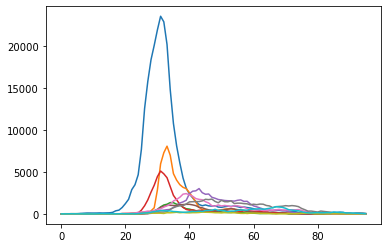

In [21]:
for i in range(1,11):
    distr = get_time_distr(upsampled_wl[upsampled_wl['purpose'] == i].end_time)
    plt.plot(distr.values)

## Trip purposes

In [7]:
resfil_raw = pd.read_csv('data/rvu/RVU_resfil.csv')
resfil_raw

,Id,Id_time,förfl_nr,lillam,lillan,storaN,Stratum,mätdag,dagtyp,dagtyp_2,bostad_komkod,bostad_tatnamn,bostad_tatkod,bostad_TatoBef,bostad_SAMS,kön,kon_tab,ålder,alder_tab,alder_grupperad,alder_tab_grupperad,Typ,Civil,Fodsvensk,Fs,reg_kon,reg_alder,hh_0_6,hh_7_10,hh_11_15,hh_16_18,hh_19_64,hh_65_74,hh_75_,hushtyp,hushtyp_4kategorier,syssels,syssels_annat,utbildn,utbildn_annat,bostad,bostad_annat,inkomst,körkort,kortkorthh,bilar,bilvidbehov,cykel,koll,kollkort,hem_buss,hem_jvg,hem_bil,arb_buss,arb_jvg,arb_bil,park_arb_1,park_arb_2,park_arb_3,park_arb_4,park_arb_5,park_arb_6,park_arb_7,park_arb_8,park_arb_9,rf1a_startadr,rf1_komkod,rf1_Tatkod,rf1_Tatnamn,rf1_Samskod,rf1_Samsnamn,rf2_starttid,starttid_timme,rf3b_äre_ann,rf3a_ärende,ärende_2,rf4a_måladr,rf4_komkod,rf4_Tatnamn,rf4_Tatkod,rf4_Samskod,rf4_Samsnamn,rf6_ankomsttid,ankomsttid_timme,rf5a_färds1,rf5b_färds2,rf5c_färds3,rf5d_färds4,rf5e_färds5,huvudfm,huvudfm_2,rf7_km,kl6_km,bostad_storst_småort_landsby,restyp,individvikt,individvikt_svarandemängd,urval_trompNr,rf1_TrompNr,rf4_TrompNr,filter_$
0,1000074.0,10000741.0,1.0,519.0,1608.0,7845.0,27.0,1.0,1.0,1.0,1284.0,Höganäs,3488.0,14205.0,12840017.0,2.0,2.0,81.0,81.0,5.0,5.0,postal,G,J,2.0,2.0,81.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,1.0,6.0,NaN,2.0,NaN,2.0,NaN,3.0,1.0,3.0,2.0,1.0,1.0,5.0,7.0,400.0,22000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1284.0,3488.0,Höganäs,12840017.0,Väsby 2,10:00,10.0,NaN,8.0,6.0,2.0,99.0,0,0.0,0.0,0,NaN,NaN,1.0,NaN,NaN,NaN,NaN,1.0,1.0,11.0,4.0,2.0,2.0,8.330817,0.201277,NaN,NaN,NaN,NaN
1,1000074.0,10000742.0,2.0,519.0,1608.0,7845.0,27.0,1.0,1.0,1.0,1284.0,Höganäs,3488.0,14205.0,12840017.0,2.0,2.0,81.0,81.0,5.0,5.0,postal,G,J,2.0,2.0,81.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,1.0,6.0,NaN,2.0,NaN,2.0,NaN,3.0,1.0,3.0,2.0,1.0,1.0,5.0,7.0,400.0,22000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,99.0,NaN,NaN,0.0,0,NaN,NaN,NaN,1.0,10.0,1.0,1284.0,Höganäs,3488.0,12840017.0,Väsby 2,NaN,NaN,1.0,NaN,NaN,NaN,NaN,1.0,1.0,11.0,4.0,2.0,2.0,8.330817,0.201277,NaN,NaN,NaN,NaN
2,1000116.0,10001161.0,1.0,2118.0,6066.0,25563.0,22.0,1.0,1.0,1.0,1283.0,Bårslöv,3376.0,2755.0,12830039.0,2.0,2.0,15.0,15.0,1.0,1.0,postal,OG,J,16.0,2.0,15.0,0.0,0.0,1.0,0.0,2.0,0.0,0.0,4.0,4.0,2.0,NaN,1.0,NaN,2.0,NaN,1.0,2.0,2.0,3.0,3.0,1.0,1.0,2.0,200.0,3000.0,10.0,350.0,1000.0,50.0,1.0,NaN,NaN,NaN,NaN,NaN,7.0,NaN,NaN,1.0,1283.0,3376.0,Bårslöv,12830039.0,Bårslöv 1 - Bårslöv Ö,9:00,9.0,NaN,4.0,2.0,2.0,1283.0,Helsingborg,3452.0,12830013.0,Maria 3 - Centrum N,9:29,9.0,3.0,NaN,NaN,NaN,NaN,3.0,2.0,8.0,3.0,3.0,2.0,22.281823,0.538341,NaN,NaN,NaN,NaN
3,1000116.0,10001162.0,2.0,2118.0,6066.0,25563.0,22.0,1.0,1.0,1.0,1283.0,Bårslöv,3376.0,2755.0,12830039.0,2.0,2.0,15.0,15.0,1.0,1.0,postal,OG,J,16.0,2.0,15.0,0.0,0.0,1.0,0.0,2.0,0.0,0.0,4.0,4.0,2.0,NaN,1.0,NaN,2.0,NaN,1.0,2.0,2.0,3.0,3.0,1.0,1.0,2.0,200.0,3000.0,10.0,350.0,1000.0,50.0,1.0,NaN,NaN,NaN,NaN,NaN,7.0,NaN,NaN,2.0,1283.0,3452.0,Helsingborg,12830013.0,Maria 3 - Centrum N,9:50,9.0,NaN,4.0,2.0,2.0,1283.0,Helsingborg,3452.0,12830011.0,Maria 1 - Olympia,10:10,10.0,3.0,NaN,NaN,NaN,NaN,3.0,2.0,3.0,2.0,3.0,2.0,22.281823,0.538341,NaN,NaN,NaN,NaN
4,1000116.0,10001163.0,3.0,2118.0,6066.0,25563.0,22.0,1.0,1.0,1.0,1283.0,Bårslöv,3376.0,2755.0,12830039.0,2.0,2.0,15.0,15.0,1.0,1.0,postal,OG,J,16.0,2.0,15.0,0.0,0.0,1.0,0.0,2.0,0.0,0.0,4.0,4.0,2.0,NaN,1.0,NaN,2.0,NaN,1.0,2.0,2.0,3.0,3.0,1.0,1.0,2.0,200.0,3000.0,10.0,350.0,1000.0,50.0,1.0,NaN,NaN,NaN,NaN,NaN,7.0,NaN,NaN,2.0,1283.0,3452.0,Helsingborg,12830011.0,Maria 1 - Olympia,11:47,11.0,NaN,4.0,2.0,2.0,1283.0,Helsingborg,3452.0,12830006.0,Maria 17 - Mariastaden,12:04,12.0,3.0,NaN,NaN,NaN,NaN,3.0,2.0,3.0,2.0,3.0,2.0,22.281823,0.538341,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,.

In [8]:
ids = resfil_raw.Id.drop_duplicates()
resfil_raw.set_index('Id', inplace=True)

In [10]:
chain = []
for i in ids:
    if type(resfil_raw.loc[i]['ärende_2']) == np.float64:
        chain.append([resfil_raw.loc[i]['ärende_2'].astype(int)])
    else:
        chain.append(resfil_raw.loc[i]['ärende_2'].values.astype(int))

In [23]:
chain_str = []
for ch in chain:
    s = ''
    for i in ch:
        s += str(i)
    chain_str.append(s)

In [25]:
df = pd.DataFrame(index=ids)
df['chain'] = chain
df['chain_str'] = chain_str

In [40]:
df.chain_str.value_counts().iloc[0:10]

110       3549
510       1485
710        816
810        711
210        591
610        409
8          296
110710     289
1510       215
10         207
Name: chain_str, dtype: int64

In [52]:
draw_population(df, resfil_raw.reset_index().drop_duplicates(subset='Id')['individvikt']).chain_str.value_counts().iloc[0:40]

110                        164125
510                         49940
210                         44685
710                         27969
810                         26604
610                         13613
8                           11830
110710                      11664
1510                         8904
110510                       8026
10                           7997
410                          6521
4110                         5660
210710                       5075
310                          5050
110810                       5048
710510                       4808
1810                         4624
41410                        4569
1710                         4478
510710                       4365
510510                       4346
1410                         4198
710710                       3815
510810                       3677
5510                         3655
110110                       3489
710810                       3135
910                          3056
3             

## Attraction/production

In [53]:
sams_w_nbuildings = pd.read_csv('data/GIS/B1_samsSW_20131231_shp/B1_sams_with_nbuildings.csv', sep=';', index_col=0)
sams_w_nbuildings['SAMSCODE'] = sams_w_nbuildings.SAMSCODE.astype(int)
sams_w_nbuildings['KOMMUN'] = sams_w_nbuildings.KOMMUN.astype(int)

In [ ]:
resfil_tours_raw = resfil_raw[resfil_raw['ärende_2'] == 1].drop_duplicates(subset=['Id'], keep='first')
upsampled_resfil_tours = draw_population(resfil_tours_raw, resfil_tours_raw.individvikt.astype(int))

attraction_rvu = upsampled_resfil_tours[(upsampled_resfil_tours['rf4_komkod'] < 2000) &
                                    (upsampled_resfil_tours['rf4_komkod'] > 100)].groupby('rf4_komkod')['Id'].count()
production_rvu = upsampled_resfil_tours[(upsampled_resfil_tours['rf1_komkod'] < 2000) &
                                    (upsampled_resfil_tours['rf1_komkod'] > 100)].groupby('rf1_komkod')['Id'].count()

production_rvu_sams = upsampled_resfil_tours[(upsampled_resfil_tours['rf1_komkod'] < 2000) &
                                    (upsampled_resfil_tours['rf1_komkod'] > 100)].groupby('rf1_Samskod')['Id'].count()
attraction_rvu_sams = upsampled_resfil_tours[(upsampled_resfil_tours['rf4_komkod'] < 2000) &
                                    (upsampled_resfil_tours['rf4_komkod'] > 100)].groupby('rf4_Samskod')['Id'].count()

In [ ]:
production_raw_rvu = resfil_tours_raw[(resfil_tours_raw['ärende_2'] == 1) &
                                (resfil_tours_raw['rf1_komkod'] < 2000) &
                                (resfil_tours_raw['rf1_komkod'] > 100)].groupby('rf1_Samskod')['Id'].count()
attraction_raw_rvu = resfil_tours_raw[(resfil_tours_raw['ärende_2'] == 1) &
                                (resfil_tours_raw['rf4_komkod'] < 2000) &
                                (resfil_tours_raw['rf4_komkod'] > 100)].groupby('rf4_Samskod')['Id'].count()

In [ ]:
rvu_vs_scb = pd.DataFrame([production_raw_rvu, 
                           sams_w_nbuildings.set_index('SAMSCODE').TotBef, 
                           production_raw_rvu / sams_w_nbuildings.set_index('SAMSCODE').TotBef,
                           production_rvu_sams
                          ], 
             index=['rvu', 'sams', 'ratio', 'upsampled_rvu']).T.sort_values(['ratio'], ascending=False)

# sams_ids = rvu_vs_scb[(rvu_vs_scb['ratio'] < 10) & (rvu_vs_scb['ratio'] > 0.03) & (rvu_vs_scb['rvu'] > 5)]
# sams_index = sams_ids.index
sams_index = sams_w_nbuildings.SAMSCODE.values

In [ ]:
a2 = read_shapefile('data/GIS/A2_samsSW_2012_shp/A2_sw_region.shp')
a2['KOMMUN'] = a2.KOMMUN.astype(int)
a2['SAMSCODE'] = a2.SAMSCODE.astype(int)
night_pop = a2[(a2.KOMMUN > 1200) & (a2.KOMMUN < 1300)]
# target_night_pop = night_pop.loc[(night_pop.KOMMUN == 1265) | (night_pop.KOMMUN == 1270)]
target_night_pop = night_pop.set_index('SAMSCODE').loc[sams_index].reset_index()
target_night_pop = target_night_pop.groupby(['SAMSCODE'])[['Totalt', 'Offentliga', 'Naringsliv']].sum()
target_night_pop.columns=[u'TotaltA2', u'OffentligaA2', u'NaringslivA2']
# other_night_pop = night_pop.loc[(night_pop.KOMMUN != 1265) & (night_pop.KOMMUN != 1270)]
other_night_pop = night_pop
other_night_pop = other_night_pop.groupby(['KOMMUN'])[['Totalt', 'Offentliga', 'Naringsliv']].sum()
other_night_pop.columns=[u'TotaltA2', u'OffentligaA2', u'NaringslivA2']

a4 = read_shapefile('data/GIS/A4_samsSW_2012_shp/A4_sw_region.shp')
a4['KOMMUN'] = a4.KOMMUN.astype(int)
a4['SAMSCODE'] = a4.SAMSCODE.astype(int)
a4 = a4[(a4.KOMMUN > 1200) & (a4.KOMMUN < 1300)]
target_day_pop = a4.set_index('SAMSCODE').loc[sams_index].reset_index()
# target_day_pop = a4.loc[(a4.KOMMUN == 1265) | (a4.KOMMUN == 1270)]
target_day_pop = target_day_pop.groupby(['SAMSCODE'])[['Totalt', 'Offentliga', 'Naringsliv']].sum()
target_day_pop.columns=[u'TotaltA4', u'OffentligaA4', u'NaringslivA4']
other_day_pop = a4
# other_day_pop = a4.loc[(a4.KOMMUN != 1265) & (a4.KOMMUN != 1270)]
other_day_pop = other_day_pop.groupby(['KOMMUN'])[['Totalt', 'Offentliga', 'Naringsliv']].sum()
other_day_pop.columns=[u'TotaltA4', u'OffentligaA4', u'NaringslivA4']

# target_buildings = sams_w_nbuildings.loc[(sams_w_nbuildings.KOMMUN == 1265) | (sams_w_nbuildings.KOMMUN == 1270)]
target_buildings = sams_w_nbuildings.set_index('SAMSCODE').loc[sams_index].reset_index()
target_buildings = target_buildings.groupby(['SAMSCODE']).sum()
# other_buildings = sams_w_nbuildings.loc[(sams_w_nbuildings.KOMMUN != 1265) & (sams_w_nbuildings.KOMMUN != 1270)]
other_buildings = sams_w_nbuildings
other_buildings = other_buildings.groupby(['KOMMUN']).sum()

#buildings = sams_w_nbuildings.groupby(['SAMSCODE'])['nProduction', 'nAttraction','TotBef', 'small_building', 'appt_build', 'multi_appartment_building'].sum()

In [ ]:
production_sams_rvu = upsampled_resfil[(upsampled_resfil['ärende_2'] == 1) &
                                    (upsampled_resfil['rf1_komkod'] < 2000) &
                                    (upsampled_resfil['rf1_komkod'] > 100)].groupby('rf1_Samskod')['Id'].count()
production_kommun_rvu = upsampled_resfil[(upsampled_resfil['ärende_2'] == 1) &
                                    (upsampled_resfil['rf1_komkod'] < 2000) &
                                    (upsampled_resfil['rf1_komkod'] > 100)].groupby('rf1_komkod')['Id'].count()

In [ ]:
target_x_sams = pd.concat([target_night_pop, target_buildings, target_day_pop], axis=1).sort_index()
other_x_sams = pd.concat([other_night_pop, other_buildings, other_day_pop], axis=1).sort_index()

all_x_sams = pd.concat([target_x_sams, other_x_sams]).sort_index()

# all_y_prod = pd.concat([target_night_pop, other_night_pop])
# all_y_att = pd.concat([target_day_pop, other_day_pop])

kommun_rvu_prod = production_kommun_rvu.sort_index()
sams_rvu_prod = production_sams_rvu.loc[sams_index].sort_index()

all_y_prod = pd.concat([kommun_rvu_prod, sams_rvu_prod]).sort_index()

In [ ]:
other_trip_scb_2018 = pd.read_csv('data/coomuting_municipalities_2018.csv', sep=';', header=[0], index_col=[0])
other_trip_scb_2018['production'] = other_trip_scb_2018['Outgoing commuters'] + other_trip_scb_2018['Work and live in county/municipality']
other_trip_scb_2018['attraction'] = other_trip_scb_2018['Incomming commuters'] + other_trip_scb_2018['Work and live in county/municipality']
other_trip_scb_2003 = pd.read_csv('data/coomuting_municipalities_2013.csv', sep=';', header=[0], index_col=[0])
other_trip_scb_2003['production'] = other_trip_scb_2003['Comuters leaving the municipality'] + other_trip_scb_2003['Working and living in the municipality']
other_trip_scb_2003['attraction'] = other_trip_scb_2003['Comuters coming into the municipality'] + other_trip_scb_2003['Working and living in the municipality']

In [ ]:
other_trip_scb_2003 = other_trip_scb_2003.dropna()
other_trip_scb_2018 = other_trip_scb_2018.dropna()

In [ ]:
other_trip_scb_raw = \
pd.concat([other_trip_scb_2018.production - (other_trip_scb_2018.production - other_trip_scb_2003.production)*5/15,
           other_trip_scb_2018.attraction - (other_trip_scb_2018.attraction - other_trip_scb_2003.attraction)*5/15,
           other_trip_scb_2018['Outgoing commuters'] - (other_trip_scb_2018['Outgoing commuters'] - other_trip_scb_2003['Comuters leaving the municipality'])*5/15,
           other_trip_scb_2018['Incomming commuters'] - (other_trip_scb_2018['Incomming commuters'] - other_trip_scb_2003['Comuters coming into the municipality'])*5/15,
           other_trip_scb_2018['Work and live in county/municipality'] - (other_trip_scb_2018['Work and live in county/municipality'] - other_trip_scb_2003['Working and living in the municipality'])*5/15,
          ],
         axis=1)
other_trip_scb_raw.columns=['production', 'attraction', 'outgoing', 'incomming', 'within']

In [ ]:
other_trip_scb_raw

In [ ]:
avg_day_c = production_kommun_rvu.sum() / other_trip_scb_raw.production.sum()
avg_day_c
other_trip_scb = other_trip_scb_raw*avg_day_c

In [ ]:
avg_day_c

# Production linear regression

In [ ]:
lin = Lasso(alpha=0.001,precompute=True,max_iter=10000, fit_intercept=False,
            positive=True, random_state=42, selection='random')

# lin = LinearRegression(fit_intercept=False, )

x_prod = other_x_sams.drop(axis=1, labels=['OffentligaA4','Ald25_44','TotBef', 'appt_build','multi_appartment_building','small_building','Ald65_W','Ald45_64','TotaltA2','Ald20_24','nIndustri','nEkonomi','TotaltA4','Ald16_19','Ald7_15','Ald0_6','nProduction','nAttraction','SAMSCODE'])
y_prod = other_trip_scb.production

# x_prod = other_x_sams.drop(axis=1, labels=['Ald20_24','TotBef','Ald65_W','Ald7_15','multi_appartment_building','nEkonomi','nIndustri','nProduction','appt_build','nAttraction','Ald16_19','Ald0_6','SAMSCODE', 'TotaltA2', 'OffentligaA2', 'NaringslivA2', 'TotaltA4', 'OffentligaA4', 'NaringslivA4'])
# y_prod = other_night_pop.TotaltA2

# x_prod = x_prod.drop(labels=[1280,1281,1283,1290,1292, 1293])
# y_prod = y_prod.drop(labels=[1280,1281,1283,1290,1292, 1293])

scaler_prod = StandardScaler(with_std=False, with_mean=False)
# scaler_att = Normalizer()
# scaler_att = MinMaxScaler()
scaler_prod.fit(x_prod)

X_prod = pd.DataFrame(scaler_prod.transform(x_prod), columns=x_prod.columns, index=x_prod.index)
production_model = lin.fit(X_prod, y_prod)
train_prod_pred = production_model.predict(X_prod)
score = r2_score(y_prod, train_prod_pred)
print('R**2 value')
print(score)
# print(pd.DataFrame(production_model.coef_, index=X_prod.columns))
print_stats(production_model, X_prod, y_prod)

In [ ]:
pred_prod_sams = pd.DataFrame(
    production_model.predict(scaler_prod.transform(target_x_sams.loc[:, X_prod.columns])), 
    index=target_x_sams.index,
    columns=['trips']
)

In [ ]:
pred_prod_sams.describe()

In [ ]:
kommun_to_sams = sams_w_nbuildings.groupby(['KOMMUN'])['SAMSCODE'].unique()
predicted_kommun_trips_from_sams = \
    pd.DataFrame([pred_prod_sams.loc[samses].sum().values for _, samses in kommun_to_sams.iteritems()], 
                 index=kommun_to_sams.index, columns=['trips_sams'])
predicted_kommun_trips_from_sams = predicted_kommun_trips_from_sams.join(other_trip_scb.production)

In [ ]:
r2_score(predicted_kommun_trips_from_sams.trips_sams, predicted_kommun_trips_from_sams.production)

In [ ]:
(predicted_kommun_trips_from_sams.trips_sams / predicted_kommun_trips_from_sams.production).describe()

# Attraction Linear regression

In [ ]:
from sklearn.linear_model import Lasso
lin = Lasso(alpha=0.001,precompute=True,max_iter=10000, fit_intercept=False,
            positive=True, random_state=42, selection='random')

x_att = other_x_sams.drop(axis=1, labels=['TotBef', 'SAMSCODE', 'Ald0_6', 'nProduction', 'nAttraction', 'multi_appartment_building', 'small_building', 'TotaltA2', 'OffentligaA2', 'NaringslivA2', 'Ald7_15', 'Ald16_19', 'Ald20_24','appt_build', 'Ald65_W', 'Ald45_64','TotaltA4', 'nEkonomi'])
y_att = other_trip_scb.attraction

# x_att = x_att.drop(labels=[1280,1281,1283,1290,1292, 1293])
# y_att = y_att.drop(labels=[1280,1281,1283,1290,1292, 1293])

# x_att_s = x_att.append(pd.DataFrame(np.zeros(len(x_att.columns)), index=x_att.columns).T)
scaler_att = StandardScaler(with_std=False, with_mean=False)
# scaler_att = Normalizer()
# scaler_att = MinMaxScaler()
scaler_att.fit(x_att)

X_att = pd.DataFrame(scaler_att.transform(x_att), columns=x_att.columns, index=x_att.index)
attraction_model = lin.fit(X_att, y_att)
train_att_pred = attraction_model.predict(X_att)
score = r2_score(y_att, train_att_pred)
print('R**2 value')
print(score)
print_stats(attraction_model, X_att, y_att)

In [ ]:
pred_att_sams = pd.DataFrame(
    attraction_model.predict(scaler_att.transform(target_x_sams.loc[:, X_att.columns])), 
    index=target_x_sams.index,
    columns=['trips']
)
pred_att_sams.describe()

In [ ]:
pred_att_sams.loc[12650000:12659999].sum()

In [ ]:
y_att[1265]

In [ ]:
pred_prod_sams.loc[12650000:12659999].sum()

In [ ]:
y_prod[1265]

In [ ]:
kommun_to_sams = sams_w_nbuildings.groupby(['KOMMUN'])['SAMSCODE'].unique()
predicted_kommun_trips_from_sams = \
    pd.DataFrame([pred_att_sams.loc[samses].sum().values for _, samses in kommun_to_sams.iteritems()], 
                 index=kommun_to_sams.index, columns=['trips_sams'])
predicted_kommun_trips_from_sams = predicted_kommun_trips_from_sams.join(other_trip_scb.attraction)

In [ ]:
r2_score(predicted_kommun_trips_from_sams.trips_sams, predicted_kommun_trips_from_sams.attraction)

In [ ]:
(predicted_kommun_trips_from_sams.trips_sams / predicted_kommun_trips_from_sams.attraction).describe()

# Gravity model for municipalities

# Gravity

In [ ]:
sams_distance_matrix = pd.read_csv('data/sams_distance_matrix_with_kommun.csv', sep=';', index_col=[0])
sams_distance_matrix.columns = sams_distance_matrix.index
#the thing above is differently sorted
sams_distance_matrix = sams_distance_matrix.sort_index().T.sort_index().T

In [ ]:
# sams_distance_matrix.replace(0, np.nan, inplace=True)
# for (idx, value) in sams_distance_matrix.loc[1200:1299, 1200:1299].min().iteritems():
#     sams_distance_matrix.at[int(idx), idx] = value * (1.0 / 3)
# for (idx, value) in sams_distance_matrix.loc[[1273, 1291], [1273, 1291]].min().iteritems():
#     sams_distance_matrix.at[int(idx), idx] = value * (1.0 / 2)

# sams_distance_matrix.at[12650001, 12650002] = sams_distance_matrix.loc[12650001].min() * (1.0 / 3)
# sams_distance_matrix.at[12650002, 12650001] = sams_distance_matrix.loc[12650002].min() * (1.0 / 3)
# sams_distance_matrix.at[12700020, 12700001] = sams_distance_matrix.loc[12700020].min() * (1.0 / 3)
# sams_distance_matrix.at[12700001, 12700020] = sams_distance_matrix.loc[12700001].min() * (1.0 / 3)
# for (idx, value) in sams_distance_matrix.loc[12650000:12659999, 12650000:12659999].min().iteritems():
#     sams_distance_matrix.at[int(idx), idx] = value * (1.0 / 3)
# for (idx, value) in sams_distance_matrix.loc[12700000:12709999, 12700000:12709999].min().iteritems():
#     sams_distance_matrix.at[int(idx), idx] = value * (1.0 / 3)
    
r = 4000
r1 = 4000
for (idx, value) in sams_distance_matrix.loc[1200:1299, 1200:1299].min().iteritems():
    sams_distance_matrix.at[int(idx), idx] = r
for (idx, value) in sams_distance_matrix.loc[12650000:12659999, 12650000:12659999].min().iteritems():
    sams_distance_matrix.at[int(idx), idx] = r1
for (idx, value) in sams_distance_matrix.loc[12700000:12709999, 12700000:12709999].min().iteritems():
    sams_distance_matrix.at[int(idx), idx] = r1
sams_distance_matrix.at[12650001, 12650002] = r
sams_distance_matrix.at[12650002, 12650001] = r
sams_distance_matrix.at[12700020, 12700001] = r
sams_distance_matrix.at[12700001, 12700020] = r

In [ ]:
fig, ax = plt.subplots()
ax.hist(sams_distance_matrix.replace(np.inf, -10000).values.flatten(), 100, log=True)
_, ax = plt.subplots()
ax.hist(upsampled_resfil_tours['rf7_km']*1000, 100, log=True)

In [ ]:
sams_distance_matrix

In [ ]:
target_x_sams = all_x_sams.loc[1200:1264].append([all_x_sams.loc[1266:1269], all_x_sams.loc[1271:1299],
                                                  all_x_sams.loc[12650000:12659999],all_x_sams.loc[12700000:12709999],])

In [ ]:
pred_prod_sams = pd.DataFrame(production_model.predict(scaler_prod.transform(target_x_sams.loc[:, x_prod.columns])), index=target_x_sams.index, columns=['predicted_production']).sort_index()
pred_attr_sams = pd.DataFrame(attraction_model.predict(scaler_att.transform(target_x_sams.loc[:, x_att.columns])), index=target_x_sams.index, columns=['predicted_attraction']).sort_index()

# pred_attr_sams_b = pred_attr_sams * (pred_prod_sams.sum().values / pred_attr_sams.sum().values)

In [ ]:
pred_prod_kommun = all_x_sams.loc[1200:1299].sort_index()
pred_prod_kommun = pd.DataFrame(production_model.predict(scaler_prod.transform(pred_prod_kommun.loc[:, x_prod.columns])), index=pred_prod_kommun.index, columns=['predicted_production']).sort_index()
pred_attr_kommun = all_x_sams.loc[1200:1299].sort_index()
pred_attr_kommun = pd.DataFrame(attraction_model.predict(scaler_att.transform(pred_attr_kommun.loc[:, x_att.columns])), index=pred_attr_kommun.index, columns=['predicted_attraction']).sort_index()

### Mean trip length from RVU

In [ ]:
rvu_mtl = upsampled_resfil_tours['rf7_km'].mean() * 1000
print(rvu_mtl)

In [ ]:
prodA = pred_prod_sams.values.flatten()
attrA = pred_attr_sams.values.flatten()
f = sams_distance_matrix.values
c=-0.00001
c2 = -0.1
cost_matrix = np.power(f, c2) * np.exp(c*f)
num_iter=10
num_iter_cal = 500
mtl = rvu_mtl
num_zones = len(prodA)
alpha = 0.1
f = f

trips = np.zeros((num_zones, num_zones))
print('Checking production, attraction balancing:')
sumP = sum(prodA)
sumA = sum(attrA)
print('Production: ', sumP)
print('Attraction: ', sumA)
if sumP != sumA:
    print('Productions and attractions do not balance, attractions will be scaled to productions!')
    attrA = attrA * (sumP / sumA)
    attrT = attrA.copy()
    prodT = prodA.copy()
else:
    print('Production, attraction balancing OK.')
    attrT = attrA.copy()
    prodT = prodA.copy()

trips = cost_matrix
#Run 2D balancing --->
computed_attractions = trips.sum(0)
computed_attractions[computed_attractions==0]=1
trips = trips * (attrT / computed_attractions)
# trips = trips.round(0)

computed_productions = trips.sum(1)
computed_productions[computed_productions==0]=1
trips = trips * np.reshape((prodT / computed_productions),[len(prodT),1])
# trips = trips.round(0)

for Iter in range(0, num_iter_cal):

    model_trip_len = np.nan_to_num(trips * f).sum() / trips.sum()
    c = c*(model_trip_len / mtl)**alpha
    cost_matrix = 0.2 * np.power(f, c2) * np.exp(c * f)
    for _ in range(0, num_iter):
        trips = cost_matrix
        #Run 2D balancing --->
        computed_attractions = trips.sum(0)
        computed_attractions[computed_attractions==0]=1
        trips = trips * (attrT / computed_attractions)
        trips = trips.round(0)

        computed_productions = trips.sum(1)
        computed_productions[computed_productions==0]=1
        trips = trips * np.reshape((prodT / computed_productions),[len(prodT),1])
#         trips = trips.round(0)
    print ('iteration: ', Iter, ' coefficient: ', c, ' average trip length (model): ', model_trip_len)

print ('target average trip length (observed): ', mtl) 
print ('final average trip length (model): ', model_trip_len)
print ('final logit scaling factor: ', c)

In [ ]:
filtered_resfil_tours = resfil_tours_raw[(resfil_tours_raw.rf1_Samskod > 1) & (resfil_tours_raw.rf4_Samskod > 1)]
filtered_resfil_tours.loc[:,'rf6_ankomsttid'] = filtered_resfil_tours.loc[:,'rf6_ankomsttid'].replace({'99':np.NaN})
filtered_resfil_tours = filtered_resfil_tours.dropna(subset=['rf2_starttid','rf6_ankomsttid', 'rf7_km'])
t1 = filtered_resfil_tours.rf2_starttid.apply(lambda t: datetime.datetime.strptime(t.strip(),'%H:%M'))
t2 = filtered_resfil_tours.rf6_ankomsttid.apply(lambda t: datetime.datetime.strptime(t.strip(),'%H:%M'))
t = t2-t1
t= t.apply(lambda x: x.seconds /60/60)
speed = filtered_resfil_tours.rf7_km / (t)
filtered_resfil_tours['speed'] = speed
filtered_resfil_tours = filtered_resfil_tours[filtered_resfil_tours.speed <= 100]
upsampled_resfil_tours = draw_population(filtered_resfil_tours, filtered_resfil_tours.individvikt.astype(int))

In [ ]:
f = sams_distance_matrix.values
bins = [0., 7001, 19000, 30000, 50000, 10000000000]
binned_distances = np.digitize(f.flatten(), bins).reshape(len(f),len(f))
observed_tld, _ = np.histogram(filtered_resfil_tours.rf7_km * 1000, bins)
observed_tld = observed_tld / (sum(observed_tld) / pred_prod_kommun.sum().sum())
observed_tld

In [ ]:
a = 227789 - observed_tld[0]
observed_tld[0] = 227789 + 50000
# observed_tld[1] = observed_tld[1] - a
# observed_tld[2] = observed_tld[2]
observed_tld = observed_tld / (sum(observed_tld) / pred_prod_kommun.sum().sum())
observed_tld

In [ ]:
observed_tld.sum()

In [ ]:
prodA = pred_prod_sams.values.flatten()
attrA = pred_attr_sams.values.flatten()
f = sams_distance_matrix.values
num_iter=100
num_iter_cal = 500
num_zones = len(prodA)
f = f
alpha = 0.1

# bins = [0., 12000 ,20000,50000,1000000]
# # bins = [_ for _ in range(0, 100000, 7000)]+[1000000]
# binned_distances = np.digitize(f.flatten(), bins).reshape(len(f),len(f))
# observed_tld, _ = np.histogram(upsampled_resfil_tours.rf7_km * 1000, bins)
# observed_tld = observed_tld / (sum(observed_tld) / pred_prod_kommun.sum().sum())

cost_matrix = np.ones([len(f), len(f)])

trips = np.zeros((num_zones, num_zones))
print('Checking production, attraction balancing:')
sumP = sum(prodA)
sumA = sum(attrA)
print('Production: ', sumP)
print('Attraction: ', sumA)
if sumP != sumA:
    print('Productions and attractions do not balance, attractions will be scaled to productions!')
    attrA = attrA * (sumP / sumA)
    attrT = attrA.copy()
    prodT = prodA.copy()
else:
    print('Production, attraction balancing OK.')
    attrT = attrA.copy()
    prodT = prodA.copy()

trips = cost_matrix*f
#Run 2D balancing --->
computed_attractions = trips.sum(0)
computed_attractions[computed_attractions==0]=1
trips = trips * (attrT / computed_attractions)
trips = trips.round(0)

computed_productions = trips.sum(1)
computed_productions[computed_productions==0]=1
trips = trips * np.reshape((prodT / computed_productions),[len(prodT),1])
trips = trips.round(0)

for Iter in range(0, num_iter_cal):

    for i in range(0, 10):
        computed_attractions = trips.sum(0)
        computed_attractions[computed_attractions==0]=1
        trips = trips * (attrT / computed_attractions)
        trips = trips.round(0)

        computed_productions = trips.sum(1)
        computed_productions[computed_productions==0]=1
        trips = trips * np.reshape((prodT / computed_productions),[len(prodT),1])
        trips = trips.round(0)

    modelled_tld = np.array([sum(trips[binned_distances == i]) for i in range(1, len(bins))])
    coeff = modelled_tld/observed_tld
    cn = []
    for c in coeff:
        if c > 1:
            cn.append(1+1/c*alpha)
        elif c < 1:
            cn.append(1-c*alpha)
        else:
            cn.append(1)
    coeff = cn
    matrix_c = np.zeros([len(f), len(f)])
    for i in range(1,len(bins)):
        matrix_c += np.array(binned_distances==i)*coeff[i-1]
    cost_matrix = cost_matrix / matrix_c
    trips = cost_matrix * f
    trips = trips.round(0)
    print(modelled_tld.astype(int))

for i in range(0, 100):
    computed_attractions = trips.sum(0)
    computed_attractions[computed_attractions==0]=1
    trips = trips * (attrT / computed_attractions)
    trips = trips.round(0)

    computed_productions = trips.sum(1)
    computed_productions[computed_productions==0]=1
    trips = trips * np.reshape((prodT / computed_productions),[len(prodT),1])
    trips = trips.round(0)
    
print(modelled_tld.astype(int))
print('observed tld')
print(observed_tld.astype(int))

In [ ]:
# trips = pd.DataFrame(Trips1, columns=sams_distance_matrix.index, index=sams_distance_matrix.index)
# trips.head()
trips = pd.DataFrame(trips.astype(int), columns=sams_distance_matrix.index, index=sams_distance_matrix.index)
trips.head()

In [ ]:
trips.sum().sum()

In [ ]:
sum(observed_tld)

### All trips after gravity vs predicted attraction / production

In [ ]:
tours_incomming_from_external = \
    upsampled_resfil_tours[((upsampled_resfil_tours['rf1_komkod'] > 2000) | 
                            (upsampled_resfil_tours['rf1_komkod'] < 100) )
                          ].groupby('rf4_komkod')['Id'].count().loc[1200:1299]
tours_outgoing_from_external = \
    upsampled_resfil_tours[((upsampled_resfil_tours['rf4_komkod'] > 2000) | 
                            (upsampled_resfil_tours['rf4_komkod'] < 100) )
                          ].groupby('rf1_komkod')['Id'].count().loc[1200:1299]

In [ ]:
def get_kommun(trips, code):
    return pd.DataFrame([[trips.loc[code, 1200:code-1].sum().sum() + trips.loc[code, code+1:1299].sum().sum(),
                         trips.loc[1200:code-1, code].sum().sum() + trips.loc[code+1:1299, code].sum().sum(),
                         trips.loc[code, code].sum().sum()
                        ]], index=[code], columns=['outgoing', 'incomming', 'within'])

In [ ]:
gravity_tours = pd.concat([get_kommun(trips, code) for code in trips.index[trips.index < 1299]])

In [ ]:
gravity_tours = pd.concat([
gravity_tours,
pd.DataFrame([[trips.loc[12650000:12659999, 1200:1299].sum().sum() + trips.loc[12650000:12659999, 12700000:12709999].sum().sum(),
                         trips.loc[1200:1299, 12650000:12659999].sum().sum() + trips.loc[12700000:12709999, 12650000:12659999].sum().sum(),
                         trips.loc[12650000:12659999, 12650000:12659999].sum().sum()
                        ]], index=[1265], columns=['outgoing', 'incomming', 'within']),
pd.DataFrame([[trips.loc[12700000:12709999, 1200:1299].sum().sum() + trips.loc[12700000:12709999, 12650000:12659999].sum().sum(),
                         trips.loc[1200:1299, 12700000:12709999].sum().sum() + trips.loc[12650000:12659999, 12700000:12709999].sum().sum(),
                         trips.loc[12700000:12709999, 12700000:12709999].sum().sum()
                        ]], index=[1270], columns=['outgoing', 'incomming', 'within']),
])

In [ ]:
gravity_tours['outgoing'] = gravity_tours['outgoing'] + tours_outgoing_from_external.reindex(index=gravity_tours.index, fill_value=0)
gravity_tours['incomming'] = gravity_tours['incomming'] + tours_incomming_from_external.reindex(index=gravity_tours.index, fill_value=0)

In [ ]:
gravity_tours.within.sum()

In [ ]:
other_trip_scb.within.sum()

In [ ]:
gravity_tours.sum().sum()

In [ ]:
other_trip_scb.sum()['production'].sum()

In [ ]:
trips.sum().sum()

In [ ]:
gravity_tours.sum().sum()

In [ ]:
other_trip_scb.sum()[['outgoing', 'incomming', 'within']].sum()

In [ ]:
pd.concat([gravity_tours, other_trip_scb], axis=1)

In [ ]:
(other_trip_scb[['incomming', 'outgoing', 'within']] / gravity_tours).describe()

In [ ]:
(other_trip_scb[['outgoing', 'incomming', 'within']].loc[[1265,1270]] / gravity_tours.loc[[1265,1270]]).describe()

In [ ]:
trips.loc[12650000:12659999]

In [ ]:
trips.to_csv('data/cheat_od.csv', index=True, header=True)

### SCB pendlare

In [ ]:
scb_pendlare = pd.read_csv('data/SCB_OD_matrix_2014.csv', sep=';').groupby(['Kommunkod', 'kommunkod'])['TOTAL'].sum().loc[1200:1299].unstack().loc[:,1200:1299]

In [ ]:
pd.concat([scb_pendlare[1265], trips.loc[12650001:12650099].sum()], axis=1)

In [ ]:
trips.loc[12650001:12650099].sum().loc[12650001:12650099].sum()

In [ ]:
print(
    trips.loc[12650001:12650099, 1281].sum().sum(), 'Lund\n',
    trips.loc[12650001:12650099, 1286].sum().sum(), 'Malmö\n',
    trips.loc[12650001:12650099, 1291].sum().sum(), 'Simrishamn\n',
    trips.loc[12650001:12650099, 1286].sum().sum(), 'Ystad\n',
)

In [ ]:
print(
    trips.loc[1281, 12650001:12650099].sum().sum(), 'Lund\n',
    trips.loc[1286, 12650001:12650099].sum().sum(), 'Malmö\n',
    trips.loc[1291, 12650001:12650099].sum().sum(), 'Simrishamn\n',
    trips.loc[1286, 12650001:12650099].sum().sum(), 'Ystad\n',
)

In [ ]:
pd.DataFrame((scb_pendlare / trips).values.flatten()).describe()

In [ ]:
r2_score(scb_pendlare, trips)

In [ ]:
fig, ax = plt.subplots()
ax.hist((scb_pendlare / trips).values.flatten(), bins=[i for i in np.arange(0.,2.,0.1)])

In [ ]:
(scb_pendlare - trips).loc[[1265,1270,1280,1264,1291,1231,1214,1275,1233,1231], [1265,1270,1280,1264,1291,1231,1214,1275,1233,1231]]